In [254]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

In [1]:
from dataloader_data import services

In [269]:
# Open the JSON file
with open('event_topics.json', 'r') as json_file:
    # Read the contents of the file
    json_data = json_file.read()
    # Parse the JSON data into a dictionary
    my_dictionary = json.loads(json_data)

In [67]:
import pandas as pd
import yaml
from pathlib import Path

def get_relevant_tags(keywords, df):
    """
    get_relevant_tags:
        from Jean-Charles. I've re-written some parts to get more statistics.

    @param keywords (str):
    @param df (pd.DataFrame): the taxonomy
    """
    df_selected = df[df.applymap(lambda x: keywords in str(x)).any(axis=1)]
    tag_dict = []
    for line_idx, line in df_selected.iterrows():
        tags_idx_int = [int(i[-1]) for i in line.index if (keywords in line[i])]
        depths = range(min(tags_idx_int), 12)
        
        tags = line.loc[['name_'+str(i) for i in depths if 'name_'+str(i) in line.index]].str.upper().values
        descriptions = line.loc[['description_'+str(i) for i in depths if 'description_'+str(i) in line.index]].values
        level = [i for i in depths if 'name_'+str(i) in line.index]
        
        tag_and_desc = list(zip(tags, descriptions, level))
        tag_dict += [i for i in tag_and_desc if i[0] != 'NAN']
    tag_dict = tag_dict = dict([(i[0], [i[1], i[2]]) for i in set(tag_dict)])
    return list(tag_dict.keys()), tag_dict

# CONSTANTS
BLOOMBERG_TAXONOMY = Path('/mnt/research-live/it-data/shared/datasets/public/DAILY/BLOOMBERG/NEWS/metadata/news_taxonomy_topics.csv')
BLOOMBERG_DESCRIPTION = Path('/home/yzhong/topic_list.csv')
df_taxonomy = pd.read_csv(BLOOMBERG_TAXONOMY).applymap(lambda x: str(x).lower())

# Get list of topics and their descriptions
df_list = pd.read_csv(BLOOMBERG_DESCRIPTION, sep=";", error_bad_lines=False)
tags_and_description = dict(zip(df_list.Code, df_list.Description))

In [34]:
def ts_scale(v, halflife=252, min_periods=126, periods=None, use_std=True, ignore_na=False, nb_bins=1):
    """
    ts_scale:
        nb_bins (int): Number of bins, to scale the halflife to nb of days.
            Default is one for our daily program, but allows to accomodate for short term programs.
    """
    halflife *= nb_bins
    min_periods *= nb_bins
    if periods is not None: 
        periods *= nb_bins

    if periods is not None:
        v_ = v.pipe(nnan_shift, periods)
    else: 
        v_ = v
    if use_std: 
        std = v_.ewm(halflife=halflife, min_periods=min_periods, ignore_na=ignore_na).std()
    else: 
        std = v_.abs().ewm(halflife=halflife, min_periods=min_periods, ignore_na=ignore_na).mean()
    return v.div(std)

def ts_demean(v, halflife=252, ignore_na=False, min_periods=0, nb_bins=1):
    halflife *= nb_bins
    min_periods *= nb_bins
    return v.sub(v.ewm(halflife, ignore_na=ignore_na, min_periods=min_periods).mean())


def ts_zscore(v, halflife=252, ignore_na=False, min_periods=126, nb_bins=1):
        return ts_scale(ts_demean(v, halflife=halflife, ignore_na=ignore_na, min_periods=min_periods, nb_bins=nb_bins), halflife=halflife, ignore_na=ignore_na, min_periods=min_periods, nb_bins=nb_bins)

In [49]:
def get_category_column(merged_df, my_dictionary):
    # Create columns in merged_df based on dictionary keys
    for key in my_dictionary.keys():
        merged_df[key] = ''

    # Split topics by space
    merged_df['topics'] = merged_df['topics'].str.split()

    # Iterate over each key in my_dictionary
    for key, value in my_dictionary.items():
        # Create a boolean mask indicating if a topic is in the list value of the current key
        mask = merged_df['topics'].apply(lambda topics: any(topic in value for topic in topics))

        # Join topics that match the current key and assign to the corresponding column
        merged_df[key] = merged_df.loc[mask, 'topics'].apply(lambda topics: ' '.join(topic for topic in topics if topic in value))

    # Strip leading/trailing spaces from the values in each key column
    for key in my_dictionary.keys():
        merged_df[key] = merged_df[key].str.strip()

    # Drop the 'topics' column
    merged_df.drop('topics', axis=1, inplace=True)

    return merged_df


In [7]:
# def get_category_column (merged_df,my_dictionary):
#     # Create columns in merged_df based on dictionary keys
#     for key in my_dictionary.keys():
#         merged_df[key] = ''

#     # Iterate over each row in merged_df
#     for index, row in merged_df.iterrows():
#         topics = row['topics'].split()  # Split topics by space

#         # Iterate over each topic
#         for topic in topics:
#             # Iterate over each key in my_dictionary
#             for key, value in my_dictionary.items():
#                 # Check if topic is in the list value of the current key
#                 if topic in value:
#                     # Append topic to the corresponding key column
#                     merged_df.at[index, key] += topic + ' '
#                     break

#     # Strip leading/trailing spaces from the values in each key column
#     for key in my_dictionary.keys():
#         merged_df[key] = merged_df[key].str.strip()
        
#     return merged_df

In [8]:
def aggregated_counts(merged_df,my_dictionary):
    merged_df=get_category_column (merged_df,my_dictionary)
    tag_columns = merged_df.columns[7:]
    # Calculate the count of topic tags for each column
    counts_df = merged_df[tag_columns].apply(lambda x: x.str.strip().str.split().apply(len))
    # Group the counts by eqt_code and date, and aggregate using sum
    aggregated_counts = counts_df.groupby([merged_df.index.get_level_values('eqt_code'), merged_df.index.get_level_values('date')]).sum()
    # Reset the index to have eqt_code and date as columns
    aggregated_counts = aggregated_counts.reset_index()
        # Select the columns from the 8th column until the last one
    tag_columns = aggregated_counts.columns[2:]
    # Get the column with the largest count for each row
    max_count_column = aggregated_counts[tag_columns].idxmax(axis=1)
    aggregated_counts['category']=max_count_column
    return aggregated_counts

In [25]:
from pathlib import Path
path = Path('/mnt/research-live/equity/reference/equity_data/sa_research/current/')
ead_ = pd.read_parquet(path /'CFM_AMER/equity_data/eqt_earning_announcement_dates.parquet') # date for earnings
ead = ead_.assign(one=1) \
          .rename(columns={'earning_date': 'BDATE'}) \
          .set_index(['BDATE', 'eqt_code']) \
          .squeeze() \
          .unstack()

In [16]:
returns=pd.read_parquet('/mnt/research-live/user/yzhong/bloomberg_news_returns_AMER.parquet')
df_news=pd.read_parquet('/mnt/research-live/user/yzhong/deduplicate_all_stocks_volumespikeUse.parquet')

In [18]:
df_news.to_parquet("/mnt/research-live/user/yzhong/deduplicate_all_stocks_volumespikeUse.parquet")

In [19]:
print(f'Number of headlines: {len(df_news)}')
df_news.head(100)

Number of headlines: 24394351


,suid,last_update,eqt_code,date,topics,headline
0,O08R5DSYF01S,2016-01-01 00:01:00.202,DDBC_DC,2016-01-01,GBN ORIGINAL FIN REGIONFILT EUROPE CEN CECO PO...,Europe Stocks: From Euphoric to Just Enviable ...
1,O08R5DSYF01S,2016-01-01 00:01:00.202,DDBC_R_DC,2016-01-01,GBN ORIGINAL FIN REGIONFILT EUROPE CEN CECO PO...,Europe Stocks: From Euphoric to Just Enviable ...
2,O08ZLH6KLVR4,2016-01-01 00:20:05.237,MU_UN,2016-01-01,METALKEY MSCIDVAS CMDKEY WORLD US SPREGIONS BI...,Einhorn’s Greenlight Fund Ends Second-Worst Ye...
3,O08ZLH6KLVR4,2016-01-01 00:20:05.237,CNX_UN,2016-01-01,METALKEY MSCIDVAS CMDKEY WORLD US SPREGIONS BI...,Einhorn’s Greenlight Fund Ends Second-Worst Ye...
4,O08ZLH6KLVR4,2016-01-01 00:20:05.237,WFR_UN,2016-01-01,METALKEY MSCIDVAS CMDKEY WORLD US SPREGIONS BI...,Einhorn’s Greenlight Fund Ends Second-Worst Ye...
...,...,...,...,...,...,...
95,O09EDDHHR9XD,2016-01-01 05:39:13.567,MSIL_IB,2016-01-01,SEASIA ACEXCLUDE EM HEADS POLIRISK WORLD SALES...,"MARUTI SUZUKI DEC. EXPORTS 7,816 UNITS."
96,O09EDDHHR9XC,2016-01-01 05:39:13.570,MSIL_IB,2016-01-01,SEASIA ACEXCLUDE EM HEADS WORLD SALES ASIAX SP...,"MARUTI SUZUKI DEC. LOCAL SALES 111,333 UNITS V..."
97,O09EHN6S9728,2016-01-01 05:41:47.971,SJET_IB,2016-01-01,OILPROD SEASIA ACEXCLUDE ORIGINAL NRG CMDKEY E...,Etihad’s Indian Partner Surges as Fuel Price D...
98,O09EHN6S9728,2016-01-01 05:41:47.971,SIA_SP,2016-01-01,OILPROD SEASIA ACEXCLUDE ORIGINAL NRG CMDKEY E...,Etihad’s Indian Partner Surges as Fuel Price D...


## Get z score

In [20]:
df_volume = df_news.groupby(['eqt_code', 'date']).size().reset_index(name='Counts')
news_volume_pivot = df_volume.pivot(index='date', columns='eqt_code', values='Counts')

In [22]:
'''
Filling the news_volume_pivot table with 0
when it first encounter a non null value
'''
for column in news_volume_pivot:
    mask = news_volume_pivot[column].notnull()
    if mask.any():
        first_valid_index = mask.idxmax()
        news_volume_pivot.loc[first_valid_index:, column].fillna(0, inplace=True)

In [27]:
# Align columns of news_volume_pivot with ead --> only looking into the US stocks
news_volume_pivot = news_volume_pivot.reindex(columns=ead.columns)

In [31]:
news_volume_pivot.index = pd.to_datetime(news_volume_pivot.index)

In [32]:
print(f'number of all eqt_code: {len(news_volume_pivot.columns.to_list())}')
unique_years = news_volume_pivot.index.year.unique()  # Get unique year indices
columns_to_drop = []

for column in news_volume_pivot.columns:
    for year in unique_years:
        values = news_volume_pivot[column][news_volume_pivot.index.year == year]
        if (values == 0).all():
            columns_to_drop.append(column)
            break
        else:
            continue

print(f'number of dropped eqt_code: {len(columns_to_drop)}')

number of all eqt_code: 4719
number of dropped eqt_code: 1293


In [35]:
news_volume_pivot_dropped = news_volume_pivot.drop(columns_to_drop, axis=1)
z_score_matrix = news_volume_pivot_dropped.apply(lambda x: ts_zscore(x, halflife=252, ignore_na=True, min_periods=126, nb_bins=1), axis=0)
z_score_unstack=z_score_matrix.stack().sort_values(ascending=False).reset_index()
columns = z_score_unstack.columns.tolist()
columns[-1] = "z_score"
z_score_unstack.columns = columns

In [39]:
z_scores = z_score_unstack['z_score']

# Calculate the quantile corresponding to the 95th percentile
quantile_95 = np.percentile(z_scores, 95)

# Print the identified value
print("The value capturing the 95th percentile of the z-score distribution is:", quantile_95)

The value capturing the 95th percentile of the z-score distribution is: 1.1686187380150046


In [286]:
len(z_scores)

10484116

Get the news dataframe with 95 percentile value

In [41]:
z_score_95 = z_score_unstack[z_score_unstack['z_score'] >= quantile_95]

In [284]:
len(z_score_95)

524206

add a filtre condition for headlines that have pact with in pact...

Get the merged dataframe with news headline

In [270]:
df_news['date'] = df_news['date'].astype(str)
z_score_95 ['date'] = z_score_95 ['date'].astype(str)
merged_df = pd.merge(df_news, z_score_95 , on=['date', 'eqt_code'], how='inner')

/opt/tmp/tmp/ipykernel_16019/1211869854.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_score_95 ['date'] = z_score_95 ['date'].astype(str)


In [271]:
merged_df

,suid,last_update,eqt_code,date,topics,headline,z_score
0,O0EIT07UT0AI,2016-01-04 00:03:00.369,HMC_UN,2016-01-04,MSCIDVAS ACEXCLUDE HEADS WORLD SPREGIONS BIZNE...,HONDA SHARES FALL 2.3% AT OPEN IN TOKYO TRADING.,2.455304
1,O0EKUZ6S9728,2016-01-04 00:47:23.107,HMC_UN,2016-01-04,MSCIDVAS ACEXCLUDE ORIGINAL WORLD SPREGIONS BI...,Takata Shares Surge After Report Automakers Ma...,2.455304
2,O0EP9B6K50XY,2016-01-04 02:22:23.964,HMC_UN,2016-01-04,MSCIDVAS ACEXCLUDE ORIGINAL FIRSTWORD WORLD BF...,"Honda Isn’t Planning Unilateral,Joint Takata I...",2.455304
3,O0ERV26S972D,2016-01-04 03:18:38.910,HMC_UN,2016-01-04,COEVNT MSCIDVAS ORIGINAL ESGCONTROV FIRSTWORD ...,Honda Says It’s Not Considering Financial Aid ...,2.455304
4,O0EU7R6S972B,2016-01-04 04:09:27.515,HMC_UN,2016-01-04,COEVNT MSCIDVAS ACEXCLUDE ESGCONTROV WORLD SPR...,Takata Shares Surge After Report Automakers Ma...,2.455304
...,...,...,...,...,...,...,...
3243188,R50132BZ8CG0,2021-12-31 21:30:38.148,ODP_UN,2021-12-31,BIZNEWS TECSVC ACEXCLUDE BBK BUSINESS BONDWIRE...,ODP SELLS COMPUCOM SYSTEMS UNIT TO VARIANT EQU...,3.726951
3243189,R50139C2Z6YO,2021-12-31 21:30:45.174,ODP_UN,2021-12-31,BIZNEWS TECSVC ACEXCLUDE BBK CPNYCNT1 BUSINESS...,ODP SELLS COMPUCOM UNIT IN A TRANSACTION VALUE...,3.726951
3243190,R5013KBYLVCW,2021-12-31 21:30:56.365,ODP_UN,2021-12-31,BIZNEWS ACEXCLUDE BBK CPNYCNT1 BUSINESS BONDWI...,ODP BOOSTS EXISTING SHARE BUYBACK AUTHORIZATIO...,3.726951
3243191,R5016JDWX2PT,2021-12-31 21:35:03.915,ODP_UN,2021-12-31,CORPFIN BIZNEWS TECSVC EQTY DIVMNA ACEXCLUDE B...,ODP Sells Compucom Unit in Deal Valued Up to $...,3.726951


In [272]:
percentage = round(len(merged_df) / len(df_news) * 100, 2)
print(f"Percentage of news after considering 95th percentile: {percentage}%")

Percentage of news after considering 95th percentile: 13.29%


In [273]:
merged_df_count=get_category_column (merged_df,my_dictionary)

In [274]:
# Create a copy of merged_df_count
tag_count_df = merged_df_count.copy()

# Apply the counting method to the tag columns
tag_columns = merged_df_count.columns[6:]  # Select the columns from the 7th column onwards
tag_count_df[tag_columns] = tag_count_df[tag_columns].applymap(lambda x: len(x.strip().split()) if isinstance(x, str) else 0)

In [275]:
aggregated_df = tag_count_df.groupby(['eqt_code', 'date'])[tag_count_df.columns[6:]].sum().reset_index()
tag_columns = aggregated_df.columns[2:]
# Get the column with the largest count for each row
max_count_column = aggregated_df[tag_columns].idxmax(axis=1)
aggregated_df['category']=max_count_column
aggregated_df.head()

,eqt_code,date,defense,product issue,jiont venture,earning,debt,rating,restructuring,clinical,dividend,disaster,index_change,financail_industry,management changes,share buyback,share offering,supplychain,merge&acquisition,CEO,FDA,Legal,new products,labor,currency_market,shut down,category
0,0330845Z_US,2013-09-20,0,0,0,3,0,0,0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,earning
1,0330845Z_US,2013-09-23,0,0,0,2,0,0,0,14,0,0,0,0,0,0,2,0,2,0,3,2,1,0,0,0,clinical
2,0330845Z_US,2013-09-24,0,0,0,2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,earning
3,0330845Z_US,2013-10-01,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,clinical
4,0330845Z_US,2013-10-03,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,clinical


In [276]:
result_df = z_score_95.merge(aggregated_df[['date', 'eqt_code', 'category']], on=['date', 'eqt_code'], how='left')

In [277]:

pivot_result_df = result_df.pivot(index='date', columns='eqt_code', values='category')

# Print the pivoted dataframe
#pivot_result_df=pivot_result_df.reindex(index=returns.index, columns=returns.columns)
pivot_result_df.index = pd.to_datetime(pivot_result_df.index)

In [278]:
# Align columns of returns with pivot_result_df
returns = returns.reindex(columns=pivot_result_df.columns)
# Align index of pivot_result_df with returns
pivot_result_df = pivot_result_df.reindex(index=returns.index)

In [265]:
# Count the not nan values in both dataframe
non_nan_count = pd.notna(pivot_result_df) & pd.notna(returns)
non_nan_count = non_nan_count.sum().sum()

print("Number of events that can be correlated to returns:", non_nan_count)

Number of events that can be correlated to returns: 331308


In [ ]:
count = np.count_nonzero(pd.notna(pivot_result_df.values))

In [289]:
returns.head()

eqt_code    0330845Z_US  1267085D_US  1318325D_US  1341694D_US  AAL_UW  \
BDATE                                                                    
2008-11-03          NaN          NaN          NaN          NaN     NaN   
2008-11-04          NaN          NaN          NaN          NaN     NaN   
2008-11-05          NaN          NaN          NaN          NaN     NaN   
2008-11-06          NaN          NaN          NaN          NaN     NaN   
2008-11-07          NaN          NaN          NaN          NaN     NaN   

eqt_code    AAOI_US  AAON_UQ   AAPL_UQ    AAP_UN  AAT_US  AAVL_US   AAWW_UW  \
BDATE                                                                         
2008-11-03      NaN      NaN  0.620282 -1.414307     NaN      NaN  2.117027   
2008-11-04      NaN      NaN -0.453435  0.860121     NaN      NaN  2.103370   
2008-11-05      NaN      NaN -1.032120 -1.313449     NaN      NaN  2.696564   
2008-11-06      NaN      NaN  0.394057  0.666048     NaN      NaN  0.348157   
2008-11-07      NaN      NaN -2.108758  0.715717     NaN      NaN  1.364351   

eqt_code       AA_UN    ABB_UN  ABCB_UQ  ABCL_US    ABC_UN   ABFS_UQ  ABG_UN  \
BDATE                                                                          
2008-11-03  1.777338 -1.809826      NaN      NaN -1.159856 -0.192009     NaN   
2008-11-04 -1.407918 -0.106524      NaN      NaN -0.276228  0.741313     NaN   
2008-11-05  2.974796  0.049008      NaN      NaN  0.813877 -2.020675     NaN   
2008-11-06 -2.496211 -2.007084      NaN      NaN -0.823822 -0.530833     NaN   
2008-11-07  2.755753 -0.111743      NaN      NaN -1.150369 -0.336469     NaN   

eqt_code    ABMD_UQ  ABM_UN  ABNB_US  ABR_UN    ABT_UN  ABV_US    ABX_CN  \
BDATE                                                                      
2008-11-03      NaN     NaN      NaN     NaN  0.288900     NaN -1.474490   
2008-11-04      NaN     NaN      NaN     NaN -1.623094     NaN -1.299142   
2008-11-05      NaN     NaN      NaN     NaN -0.320747     NaN  1.558960   
2008-11-06      NaN     NaN      NaN     NaN -0.409338     NaN  0.616875   
2008-11-07      NaN     NaN      NaN     NaN  0.487848     NaN -0.325799   

eqt_code    ABX_UN  ABY_US  ACAD_UQ  ACA_US  ACB_CT  ACB_US  ACCD_US_1  \
BDATE                                                                    
2008-11-03     NaN     NaN      NaN     NaN     NaN     NaN        NaN   
2008-11-04     NaN     NaN      NaN     NaN     NaN     NaN        NaN   
2008-11-05     NaN     NaN      NaN     NaN     NaN     NaN        NaN   
2008-11-06     NaN     NaN      NaN     NaN     NaN     NaN        NaN   
2008-11-07     NaN     NaN      NaN     NaN     NaN     NaN        NaN   

eqt_code    ACC_UN    ACE_UN   ACGL_UW  ACHC_UQ  ACH_US    ACI_UN  ACLS_UQ  \
BDATE                                                                        
2008-11-03     NaN -2.600396 -2.998523      NaN     NaN  1.204105      NaN   
2008-11-04     NaN -1.713326 -1.627219      NaN     NaN -1.643630      NaN   
2008-11-05     NaN -0.470618 -3.203753      NaN     NaN  0.744080      NaN   
2008-11-06     NaN  0.613467 -2.942668      NaN     NaN -3.614388      NaN   
2008-11-07     NaN  1.435052 -2.038113      NaN     NaN  0.922762      NaN   

eqt_code    ACMR_UQ_1  ACM_US    ACN_UN   ACOR_UQ  ACO_X_CT  ACTC_US  \
BDATE                                                                  
2008-11-03        NaN     NaN -2.806047  1.099914       NaN      NaN   
2008-11-04        NaN     NaN -0.294047  0.920906       NaN      NaN   
2008-11-05        NaN     NaN -2.203862 -0.348397       NaN      NaN   
2008-11-06        NaN     NaN -1.758289 -0.590760       NaN      NaN   
2008-11-07        NaN     NaN  1.073185 -0.080898       NaN      NaN   

eqt_code    ACTG1_UQ  ACXM_UQ  AC_B_CT   ADBE_UQ  ADC_UN  ADHD_US    ADI_UN  \
BDATE                                                                         
2008-11-03       NaN      NaN      NaN  2.404819     NaN      NaN -1.416265   
2008-11-04       NaN     

In [266]:
def get_mask(pivot_result_df, category):
    # Create a copy of the original dataframe
    mask = pivot_result_df.copy()
    # Replace cell values equal to category with 1, and others with NaN
    mask = mask.where(mask == category, np.nan).where(mask != category, 1)
    return mask

In [280]:
def get_plot (pivot_result_df, category, returns):
    mask=get_mask(pivot_result_df, category)
    averages = pd.Series({-i: np.nanmean((mask.shift(-i) * returns).values)for i in range(-11, 5)})
    averages.plot.bar()
    plt.xlabel('Shift')
    plt.ylabel('Average')
    plt.title(f'Lead-lag analysis on category {category}')
    plt.show()

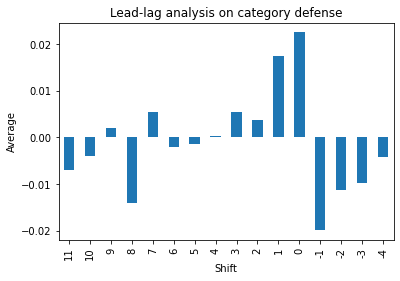

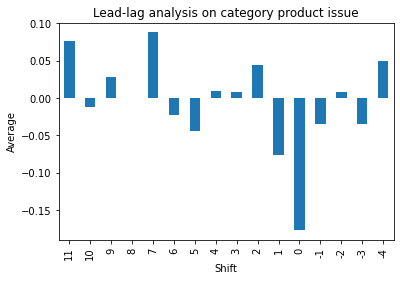

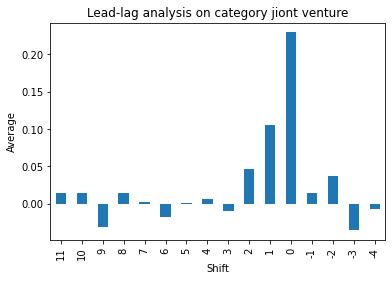

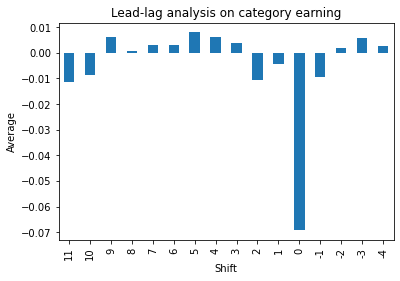

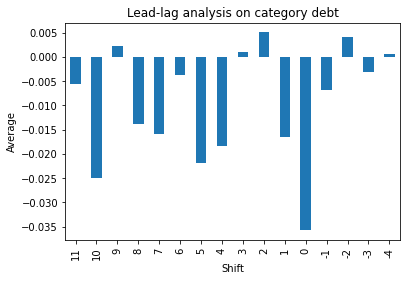

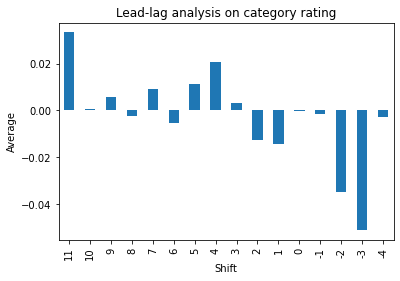

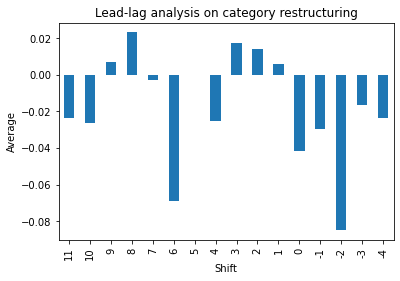

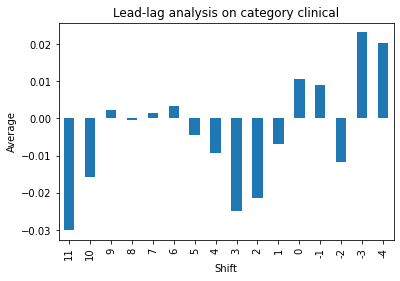

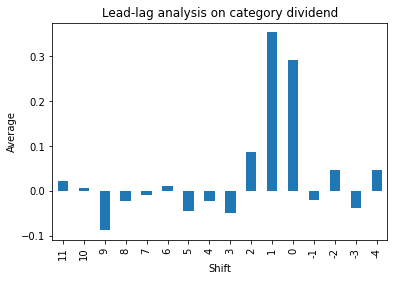

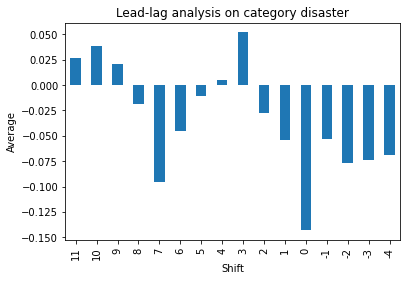

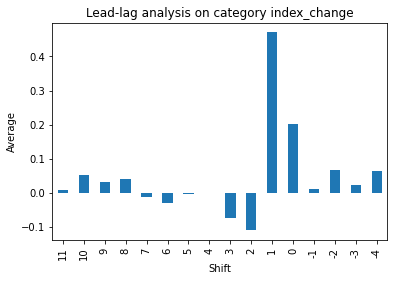

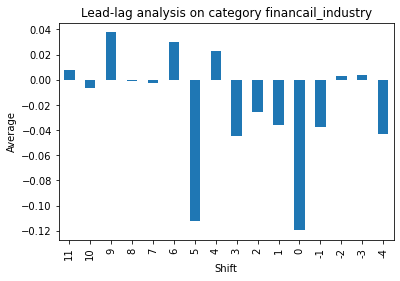

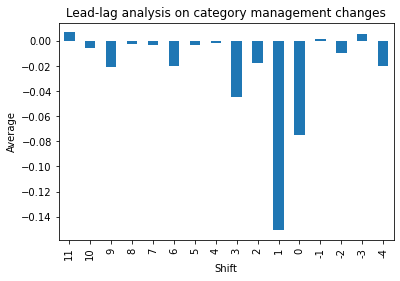

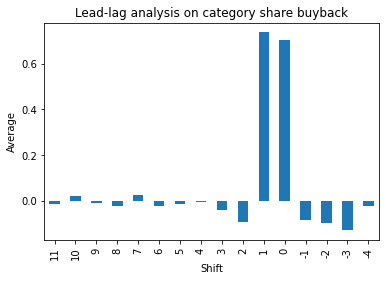

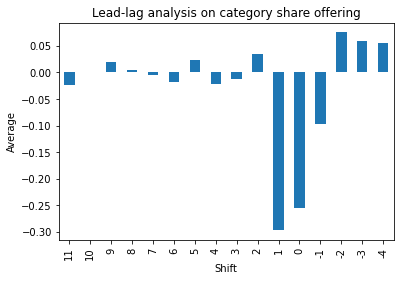

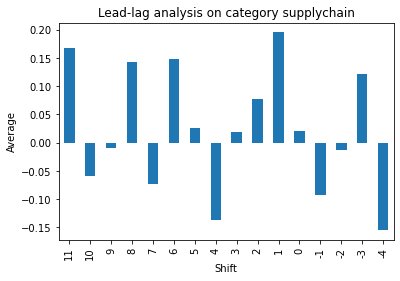

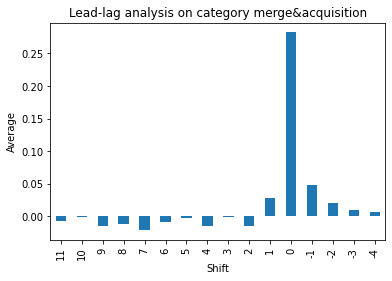

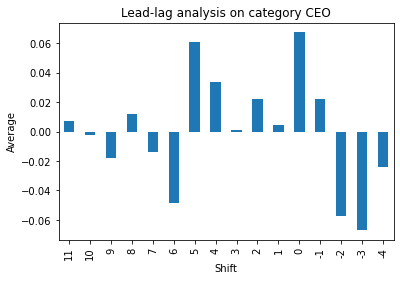

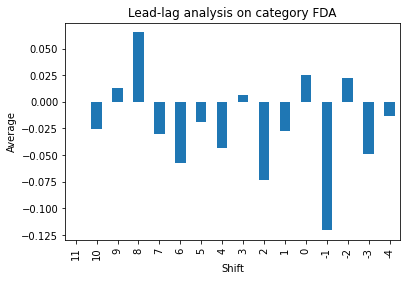

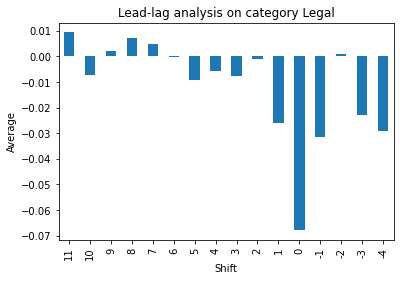

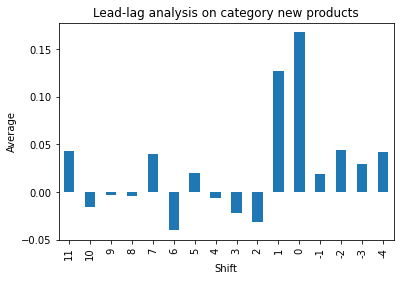

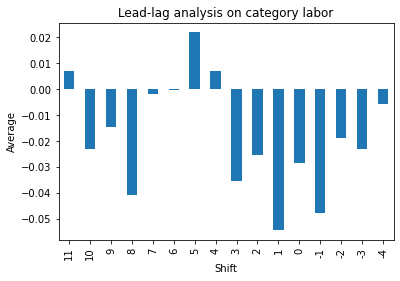

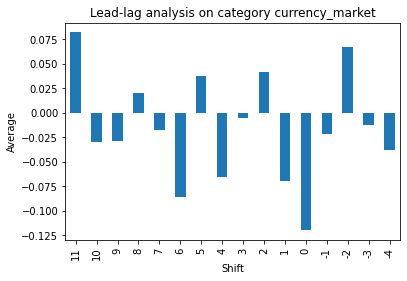

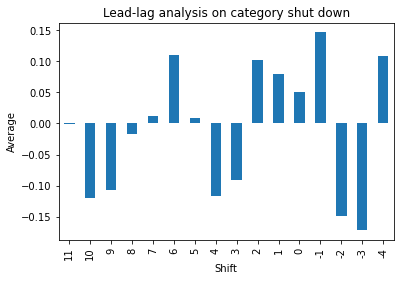

In [281]:
for category, _ in my_dictionary.items():
    get_plot(pivot_result_df, category, returns)

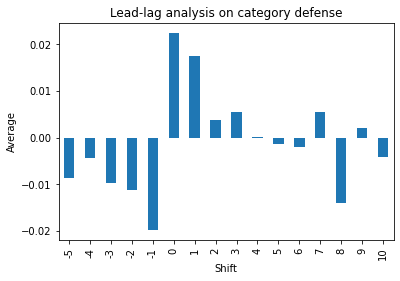

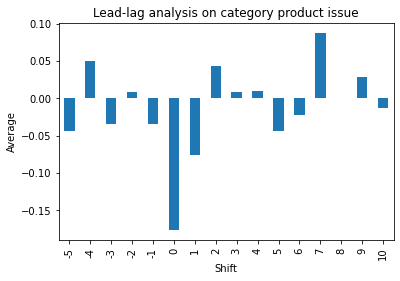

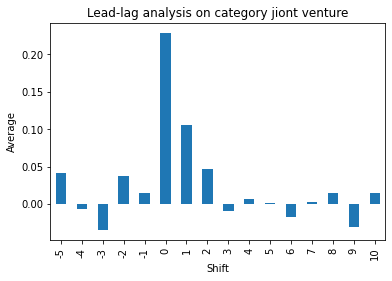

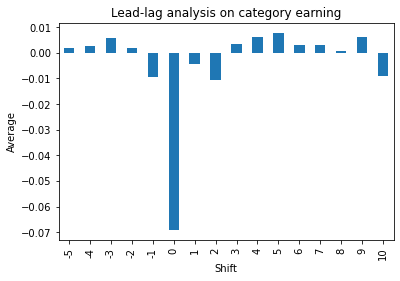

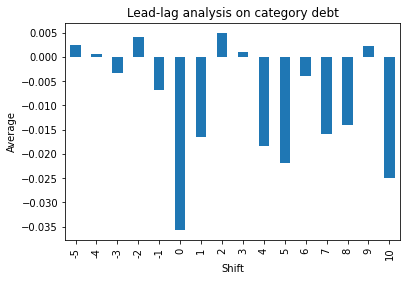

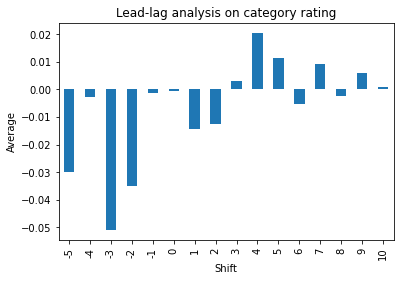

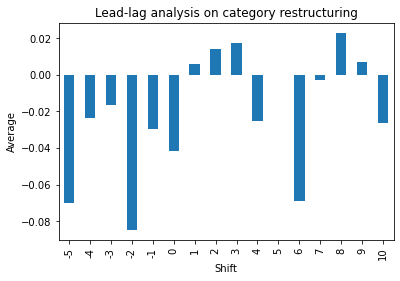

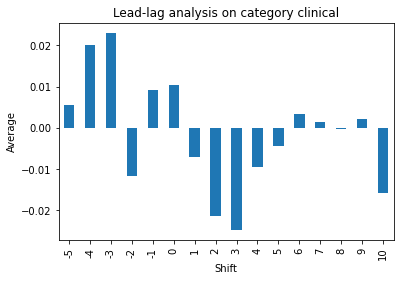

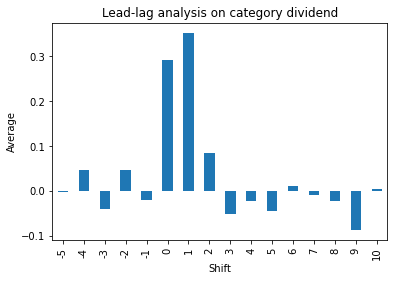

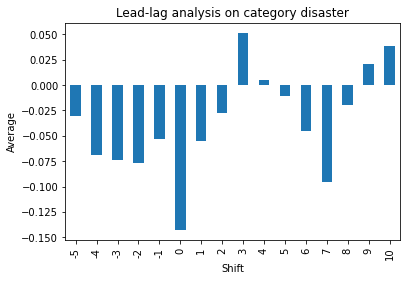

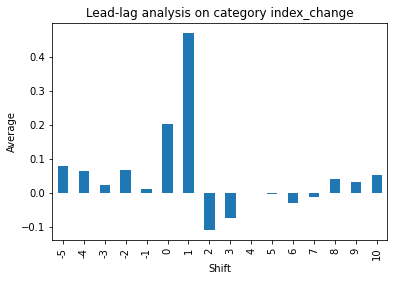

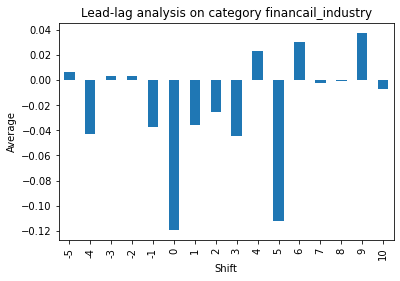

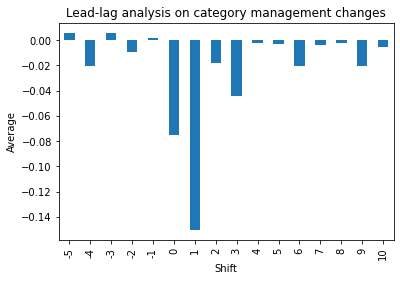

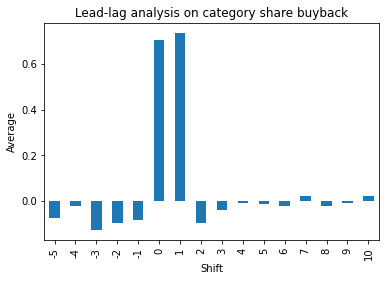

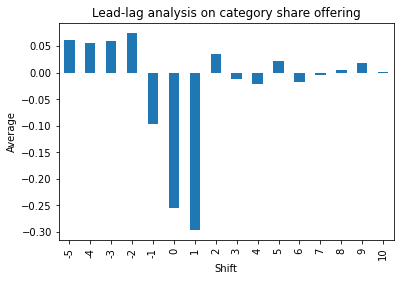

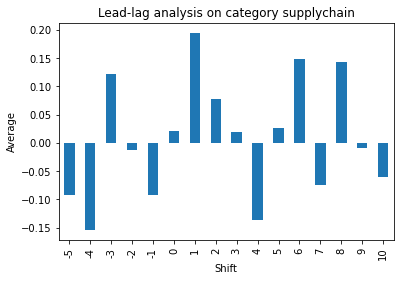

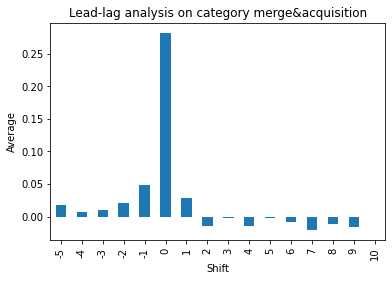

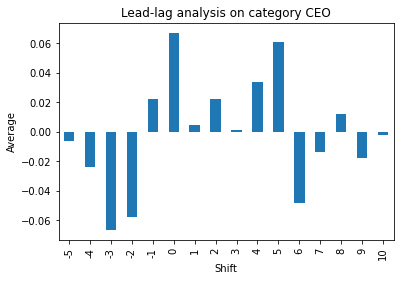

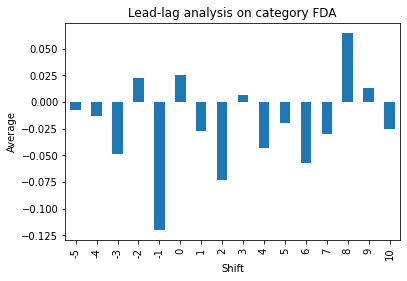

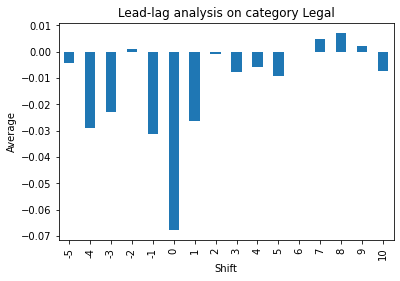

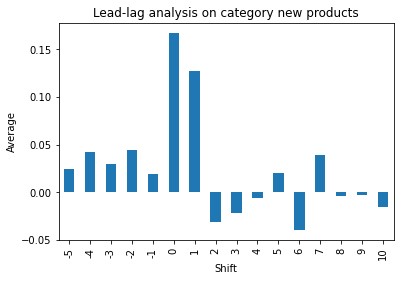

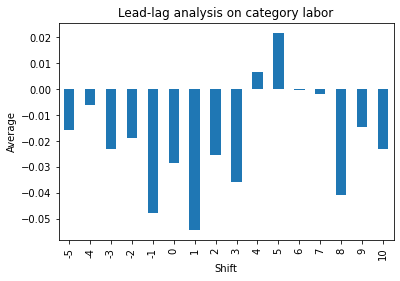

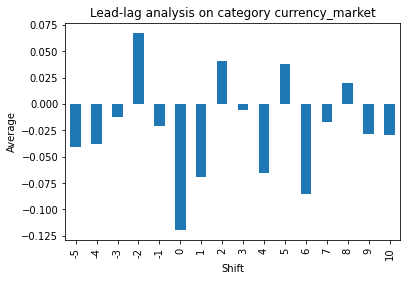

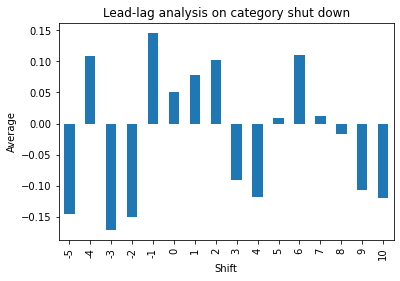

In [279]:
for category, _ in my_dictionary.items():
    get_plot(pivot_result_df, category, returns)

In [244]:
mask_defense=get_mask(pivot_result_df, 'shut down')

In [238]:
multiplied_df = mask_defense * returns

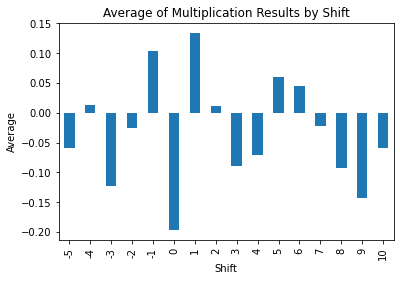

In [252]:
averages = pd.Series({i: np.nanmean((mask_defense.shift(i) * returns).values)for i in range(-5, 11)})
averages.plot.bar()
plt.xlabel('Shift')
plt.ylabel('Average')
plt.title('Average of Multiplication Results by Shift')
plt.show()

In [240]:
average_value = np.nanmean(multiplied_df.values)
average_value

0.044053389582848206

In [239]:
count = np.count_nonzero(pd.notna(multiplied_df.values))
print(count)


3788


In [235]:
count = np.count_nonzero(pd.notna(mask_defense.values))
print(count)

6118


<AxesSubplot:>

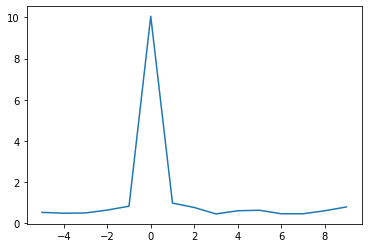

In [232]:
import pandas as pd
from pathlib import Path
path = Path('/mnt/research-live/equity/reference/equity_data/sa_research/current/')

 

ead_ = pd.read_parquet(path /'CFM_AMER/equity_data/eqt_earning_announcement_dates.parquet')
news_volume_ =  pd.read_parquet(path /'CFM_AMER/equity_data/eqt_bb_news_volumes.parquet')

 

ead = ead_.assign(one=1).rename(columns={'earning_date': 'BDATE'})\
                                        .set_index(['BDATE', 'eqt_code'])\
                                        .squeeze()\
                                        .unstack()

 

news_volume = news_volume_.rename(columns={'daclose':'BDATE'}).groupby(['BDATE', 'eqt_code'])['total_count'].mean().unstack()

 

df = news_volume.pipe(lambda x: x.div(x.rolling(window=126, min_periods=42).mean()))

 

df2 =  ead.reindex_like(df)

 

c = 'MCD_UN'
pd.Series({i: df[c].mul(df2[c].shift(i)).median() for i in range(-5, 10)}).plot()

In [210]:
for key in my_dictionary.keys():
    print (key)

defense
product issue
jiont venture
earning
debt
rating
restructuring
clinical
dividend
disaster
index_change
financail_industry
management changes
share buyback
share offering
supplychain
merge&acquisition
CEO
FDA
Legal
new products
labor
currency_market
shut down


In [208]:
pivot_result_df

eqt_code   0330845Z_US 1267085D_US 1318325D_US 1341694D_US AAL_UW AAOI_US  \
BDATE                                                                       
2008-11-03         NaN         NaN         NaN         NaN    NaN     NaN   
2008-11-04         NaN         NaN         NaN         NaN    NaN     NaN   
2008-11-05         NaN         NaN         NaN         NaN    NaN     NaN   
2008-11-06         NaN         NaN         NaN         NaN    NaN     NaN   
2008-11-07         NaN         NaN         NaN         NaN    NaN     NaN   
...                ...         ...         ...         ...    ...     ...   
2023-05-03         NaN         NaN         NaN         NaN    NaN     NaN   
2023-05-04         NaN         NaN         NaN         NaN    NaN     NaN   
2023-05-05         NaN         NaN         NaN         NaN    NaN     NaN   
2023-05-08         NaN         NaN         NaN         NaN    NaN     NaN   
2023-05-09         NaN         NaN         NaN         NaN    NaN     NaN   

eqt_code   AAON_UQ AAPL_UQ AAP_UN AAT_US AAVL_US AAWW_UW AA_UN ABB_UN ABCB_UQ  \
BDATE                                                                           
2008-11-03     NaN     NaN    NaN    NaN     NaN     NaN   NaN    NaN     NaN   
2008-11-04     NaN     NaN    NaN    NaN     NaN     NaN   NaN    NaN     NaN   
2008-11-05     NaN     NaN    NaN    NaN     NaN     NaN   NaN    NaN     NaN   
2008-11-06     NaN     NaN    NaN    NaN     NaN     NaN   NaN    NaN     NaN   
2008-11-07     NaN     NaN    NaN    NaN     NaN     NaN   NaN    NaN     NaN   
...            ...     ...    ...    ...     ...     ...   ...    ...     ...   
2023-05-03     NaN     NaN    NaN    NaN     NaN     NaN   NaN    NaN     NaN   
2023-05-04     NaN     NaN    NaN    NaN     NaN     NaN   NaN    NaN     NaN   
2023-05-05     NaN     NaN    NaN    NaN     NaN     NaN   NaN    NaN     NaN   
2023-05-08     NaN     NaN    NaN    NaN     NaN     NaN   NaN    NaN     NaN   
2023-05-09     NaN     NaN    NaN    NaN     NaN     NaN   NaN    NaN     NaN   

eqt_code   ABCL_US ABC_UN ABFS_UQ ABG_UN ABMD_UQ ABM_UN ABNB_US ABR_UN ABT_UN  \
BDATE                                                                           
2008-11-03     NaN    NaN     NaN    NaN     NaN    NaN     NaN    NaN    NaN   
2008-11-04     NaN    NaN     NaN    NaN     NaN    NaN     NaN    NaN    NaN   
2008-11-05     NaN    NaN     NaN    NaN     NaN    NaN     NaN    NaN    NaN   
2008-11-06     NaN    NaN     NaN    NaN     NaN    NaN     NaN    NaN    NaN   
2008-11-07     NaN    NaN     NaN    NaN     NaN    NaN     NaN    NaN    NaN   
...            ...    ...     ...    ...     ...    ...     ...    ...    ...   
2023-05-03     NaN    NaN     NaN    NaN     NaN    NaN     NaN    NaN    NaN   
2023-05-04     NaN    NaN     NaN    NaN     NaN    NaN     NaN    NaN    NaN   
2023-05-05     NaN    NaN     NaN    NaN     NaN    NaN     NaN    NaN    NaN   
2023-05-08     NaN    NaN     NaN    NaN     NaN    NaN     NaN    NaN    NaN   
2023-05-09     NaN    NaN     NaN    NaN     NaN    NaN     NaN    NaN    NaN   

eqt_code   ABV_US ABX_CN ABX_UN ABY_US ACAD_UQ ACA_US ACB_CT ACB_US ACCD_US_1  \
BDATE                                                                           
2008-11-03    NaN    NaN    NaN    NaN     NaN    NaN    NaN    NaN       NaN   
2008-11-04    NaN    NaN    NaN    NaN     NaN    NaN    NaN    NaN       NaN   
2008-11-05    NaN    NaN    NaN    NaN     NaN    NaN    NaN    NaN       NaN   
2008-11-06    NaN    NaN    NaN    NaN     NaN    NaN    NaN    NaN       NaN   
2008-11-07    NaN    NaN    NaN    NaN     NaN    NaN    NaN    NaN       NaN   
...           ...    ...    ...    ...     ...    ...    ...    ...       ...   
2023-05-03    NaN    NaN    NaN    NaN     NaN    NaN    NaN    NaN       NaN   
2023-05-04    NaN    NaN    NaN    NaN     NaN    NaN    NaN    NaN       NaN   
2023-05-05    NaN    NaN    NaN    NaN     NaN    NaN    NaN    NaN       NaN   

In [144]:
result_df.to_parquet('/mnt/research-live/user/yzhong/result_topic_volume_spike.parquet')

In [98]:
tag_list=df_news[(df_news['eqt_code']=='SBUX_UQ')&(df_news['date']=='2016-01-14')].topics.to_list()

In [103]:
tags_list = [tag for element in tag_list for tag in element.split()]

# Get unique tags using set()
unique_tags = list(set(tags_list))

In [104]:
second_query =unique_tags

for item in second_query:
    print(f"{item}: {tags_and_description.get(item)}")

POLIRISK: Political Risk
GOV: Government News
DEF: Defense Dept., Militaries
USWE: U.S. West
DC: District of Columbia
FIRSTWORD: First Word
GEN: General
BFWEQ: First Word Equity News
WORLD: Regions
SPACE: Space Exploration
G7MEMB: G7 Countries
BGOVCODES: BGOV Codes
PADDIST: Petroleum Area Def Districts
INDUSTRIAL: Industrials
COS: Company News
INDUSTRIES: Industries
USGOV: U.S. Government
NASA: NASA
BFW: Bloomberg First Word
PADD5: Petroleum Area Def District 5
NORTHAM: North America
MSCINAMER: MSCI North America
BONDWIRES: Eligible Wires for Bond CN
ACEXCLUDE: Excluded From Alert Catcher
ESGCOUNT: None
MAJOR: Major News Stories
SCIENCE: Science
MISC: Miscellaneous
CMP: Computer Generated
ESGWEAPON: None
ARO: Aerospace & Defense
BIZNEWS: Bus, Eco, Govt News
CA: California
DIRECTHEAD: As Is Headlined Press Rls
BFWUS: First Word Equity U.S.
FINNEWS: Fin'l News Nupes
US: United States of America
ALLSTATES: All U.S. States Codes
MSCIWORLD: MSCI Regions
SRCRANK1: Rank 1 Sources
G10MEMB: Gro

In [73]:
rows_with_all_nan = merged_df_count[merged_df_count.iloc[:, 6:].isnull().all(axis=1)]
rows_with_all_nan[100:200]

,suid,last_update,eqt_code,date,headline,z_score,earning,debt,rating,restructuring,clinical,dividend,disaster,index_change,financail_industry,management changes,share buyback,share offering,supplychain,merge&acquisition,CEO,Leisure,FDA,Legal,new products,labor,currency_market,shut down
0,O0EIT07UT0AI,2016-01-04 00:03:00.369,HMC_UN,2016-01-04,HONDA SHARES FALL 2.3% AT OPEN IN TOKYO TRADING.,2.455304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,O0EKUZ6S9728,2016-01-04 00:47:23.107,HMC_UN,2016-01-04,Takata Shares Surge After Report Automakers Ma...,2.455304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,O0EP9B6K50XY,2016-01-04 02:22:23.964,HMC_UN,2016-01-04,"Honda Isn’t Planning Unilateral,Joint Takata I...",2.455304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,O0ERV26S972D,2016-01-04 03:18:38.910,HMC_UN,2016-01-04,Honda Says It’s Not Considering Financial Aid ...,2.455304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,O0EU7R6S972B,2016-01-04 04:09:27.515,HMC_UN,2016-01-04,Takata Shares Surge After Report Automakers Ma...,2.455304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243181,R4ZM87T0AFB6,2021-12-31 18:13:28.099,DOYU_US,2021-12-31,"Didi Slumps After Rally, Leads Dip in U.S.-Lis...",2.186978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3243182,R4ZZL5T1UM0W,2021-12-31 21:40:52.162,DOYU_US,2021-12-31,"Didi Falls After Rally, Leads Dip in US-Listed...",2.186978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3243188,R50132BZ8CG0,2021-12-31 21:30:38.148,ODP_UN,2021-12-31,ODP SELLS COMPUCOM SYSTEMS UNIT TO VARIANT EQU...,3.726951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3243189,R50139C2Z6YO,2021-12-31 21:30:45.174,ODP_UN,2021-12-31,ODP SELLS COMPUCOM UNIT IN A TRANSACTION VALUE...,3.726951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
pd.set_option('display.max_columns', None)
merged_df_count.head(100)

,suid,last_update,eqt_code,date,headline,z_score,earning,debt,rating,restructuring,clinical,dividend,disaster,index_change,financail_industry,management changes,share buyback,share offering,supplychain,merge&acquisition,CEO,Leisure,FDA,Legal,new products,labor,currency_market,shut down
0,O0EIT07UT0AI,2016-01-04 00:03:00.369,HMC_UN,2016-01-04,HONDA SHARES FALL 2.3% AT OPEN IN TOKYO TRADING.,2.455304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,O0EKUZ6S9728,2016-01-04 00:47:23.107,HMC_UN,2016-01-04,Takata Shares Surge After Report Automakers Ma...,2.455304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,O0EP9B6K50XY,2016-01-04 02:22:23.964,HMC_UN,2016-01-04,"Honda Isn’t Planning Unilateral,Joint Takata I...",2.455304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,O0ERV26S972D,2016-01-04 03:18:38.910,HMC_UN,2016-01-04,Honda Says It’s Not Considering Financial Aid ...,2.455304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,O0EU7R6S972B,2016-01-04 04:09:27.515,HMC_UN,2016-01-04,Takata Shares Surge After Report Automakers Ma...,2.455304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,O0FD846K50YH,2016-01-04 11:00:04.888,SU_CN,2016-01-04,CANADIAN OIL SANDS ISSUES DECLARATION OF INDEP...,5.116709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,O0FD8T6K50Y8,2016-01-04 11:00:29.793,SU_CN,2016-01-04,CANADIAN OIL SAYS WASN'T LOOKING TO SELL ITSELF.,5.116709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,O0FD8U6K50XV,2016-01-04 11:00:30.869,SU_CN,2016-01-04,CANADIAN OIL SANDS SAYS BEST SERVED BY BEING I...,5.116709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,O0FD956K50Y8,2016-01-04 11:00:41.395,SU_CN,2016-01-04,CANADIAN OIL SANDS CONTINUES TO TAKE STEPS TO ...,5.116709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
z_scores = z_score_unstack['z_score']

# Calculate the length of the dataframe where z_score > 1.17
count_greater_than_threshold = len(z_scores[z_scores > 1.17])

# Calculate the proportion by dividing the count by the total length of the dataframe
proportion = count_greater_than_threshold / len(z_scores)

# Print the calculated proportion
print("Proportion of rows with z_score > 1.17:", proportion)

Proportion of rows with z_score > 1.17: 0.04994879873515325


In [ ]:
get_category_column (df_news,my_dictionary)

In [10]:
aggregated_counts=aggregated_counts(df_news,my_dictionary)

KeyError: 'Requested level (eqt_code) does not match index name (None)'

In [ ]:
aggregated_counts

In [6]:
my_dictionary

{'debt': ['CNI', 'DISTRESSED'],
 'rating': ['CRA', 'DRA', 'CREDITCG', 'CREDITUP'],
 'restructuring': ['RESTRUCT', 'BCY'],
 'clinical': ['CTRLSS',
  'CLNTRLNON',
  'CLNTRIAL',
  'CTRLP1',
  'CTRLP2',
  'CTRLSNL',
  'CTRLP4',
  'CTRLST',
  'CTRLSEP',
  'CTRLSNY',
  'CTRLSC',
  'CTRLSR',
  'CTRLP3',
  'CTRLSW',
  'ASCO',
  'ILLNESS'],
 'dividend': ['DIVCUTEVT', 'DIVSPL', 'DIVBFW', 'DIVDEC'],
 'disaster': ['DROUGHT',
  'WATERRISK',
  'HURRICANE',
  'VOLCANO',
  'NATRISK',
  'QUAKE',
  'NAT',
  'DRECOVER',
  'SOLARSTORM',
  'QUAKEANNC',
  'TSUNAMI',
  'FLOOD'],
 'index_change': ['NDXCHG', 'NDX'],
 'financail_industry': ['FINTECH'],
 'management changes': ['MGMTCHG', 'CEOCHG'],
 'share buyback': ['BBKNEW'],
 'share offering': ['NEWSTKK', 'ADDL', 'PLACE'],
 'supplychain': ['SUPPLYDISR'],
 'merge&acquisition': ['MNA'],
 'CEO': ['CEO'],
 'Leisure': ['LEI'],
 'FDA': ['FDA'],
 'Legal': ['PATENT', 'LAWSUITS', 'IPLAW', 'LAWPRAC'],
 'new products': ['NP', 'BINWPRD'],
 'labor': ['LABOR', 'HARASS', 'G